## Indian Liver Disease Patients: Smote & Classification (5/5)

In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, f1_score,precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../input/indian-liver-patients-feature-selection-2-5/liver_reduced_features.csv')

In [3]:
X = df.iloc[:,:-1] # independent 
y = df.iloc[:,-1] #target

In [4]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({1: 416, 0: 167})


## SMOTE Implementation

In [5]:
over = SMOTE(sampling_strategy = 0.8) #oversample the minority class

In [6]:
X, y = over.fit_resample(X, y)

In [7]:
counter = Counter(y)
print(counter)

Counter({1: 416, 0: 332})


In [8]:
under = RandomUnderSampler(sampling_strategy=1) #undersample the majority class

In [9]:
X, y = under.fit_resample(X, y)

In [10]:
counter = Counter(y)
print(counter)

Counter({0: 332, 1: 332})


## Scale the Data & PCA

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
pca = PCA(n_components = 2)
pca.fit(X_scaled)

PCA(n_components=2)

In [14]:
X_scaled_pca = pca.transform(X_scaled)

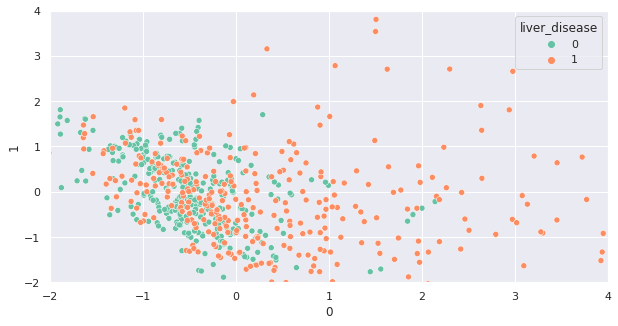

In [15]:
sns.set_theme()
plt.figure(figsize = (10,5))
sns.scatterplot(x =pd.DataFrame(X_scaled_pca)[0], y = pd.DataFrame(X_scaled_pca)[1], hue = y, palette = 'Set2')
plt.xlim(-2, 4)
plt.ylim(-2, 4)
plt.show()

In [16]:
smote_df = X 
smote_df['liver_disease'] = y

## Scale the Data

In [17]:
scaler = StandardScaler()
X = smote_df.iloc[:,:-1].values #features
y = smote_df.iloc[:,-1].values.reshape(664,1) #targer

X_scaled = StandardScaler().fit_transform(X) #scale features

In [18]:
#Cross Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

## Classifiers

In [19]:
lr = LogisticRegression(random_state=1)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(max_depth=10, min_samples_split = 5)
#mlp = MLPClassifier(hidden_layer_sizes=(1,9), activation='logistic', solver='sgd', alpha=1e-5, learning_rate='adaptive', random_state=100, verbose=False)
classifiers = [lr, nb, knn, rf]

In [20]:
d = {}
l = ['Logistic Regression', 'Naive Bayes', 'kNN', 'Random Forest']
i = 0
metrics = pd.DataFrame(columns = ['Accuracy','F1 Score','Sensitivity', 'Specificity', 'AUC']) 
for clf in classifiers:
    clf_accuracy = []
    clf_f1_score = []
    clf_specificity = []
    clf_sensitivity = []
    clf_auc = []
    tprs = []
    mean_fpr = []
    
    for train_index, test_index in cv.split(X_scaled, y.ravel()):
        #train test split
        x_train_fold, x_test_fold = X_scaled[train_index], X_scaled[test_index] 
        y_train_fold, y_test_fold = y.ravel()[train_index], y.ravel()[test_index] 
        
        #fit the model
        clf.fit(x_train_fold, y_train_fold)
        
        #prediction
        y_pred = clf.predict(x_test_fold)
        
        #confusion matrix
        cm = confusion_matrix(y_test_fold,y_pred)
        
        tp = cm[1][1]
        tn = cm[0][0]
        fp = cm[0][1]
        fn = cm[1][0]
        
        accuracy = (tp + tn) /(tp + tn + fp + fn)
        precision = (tp) / (tp + fp)
        recall = (tp) / (tp + fn)
        f1score = (2 * precision * recall) / (precision + recall)
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        #auc score
        prediction = clf.fit(x_train_fold,y_train_fold).predict_proba(x_test_fold)
        
        fpr, tpr, t = roc_curve(y_test_fold.ravel(), prediction[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        
        
        #append the scores
        clf_accuracy.append(accuracy)
        clf_f1_score.append(f1score)
        clf_sensitivity.append(sensitivity)
        clf_specificity.append(specificity)
        clf_auc.append(roc_auc)
    
    
    d[l[i]]={'Accuracy': sum(clf_accuracy)/10,'F1 Score': sum(clf_f1_score)/10, 'Sensitivity': sum(clf_sensitivity)/10,'Specificity': sum(clf_specificity)/10, 'AUC': sum(clf_auc)/10}
    i+=1
    #metrics.loc[-1] = d  # adding a row
    #metrics.index = metrics.index + 1  # shifting index
    #metrics = metrics.sort_index()  # sorting by index

In [21]:
d

{'Logistic Regression': {'Accuracy': 0.7078697421981004,
  'F1 Score': 0.6552735300621496,
  'Sensitivity': 0.5600713012477719,
  'Specificity': 0.8552584670231729,
  'AUC': 0.758134824177605},
 'Naive Bayes': {'Accuracy': 0.6777476255088196,
  'F1 Score': 0.5514128164916119,
  'Sensitivity': 0.40356506238859186,
  'Specificity': 0.9516934046345812,
  'AUC': 0.7461797115540431},
 'kNN': {'Accuracy': 0.6807553143374039,
  'F1 Score': 0.6308919487221374,
  'Sensitivity': 0.5512477718360071,
  'Specificity': 0.8098930481283423,
  'AUC': 0.7300167449900072},
 'Random Forest': {'Accuracy': 0.763681592039801,
  'F1 Score': 0.7436310426136712,
  'Sensitivity': 0.6896613190730838,
  'Specificity': 0.837433155080214,
  'AUC': 0.8354885755955275}}

In [22]:
for i in l:
    metrics = metrics.append(d[i], ignore_index = True)

In [23]:
metrics['Classifier'] = l

In [24]:
metrics

,Accuracy,F1 Score,Sensitivity,Specificity,AUC,Classifier
0,0.707870,0.655274,0.560071,0.855258,0.758135,Logistic Regression
1,0.677748,0.551413,0.403565,0.951693,0.746180,Naive Bayes
2,0.680755,0.630892,0.551248,0.809893,0.730017,kNN
3,0.763682,0.743631,0.689661,0.837433,0.835489,Random Forest


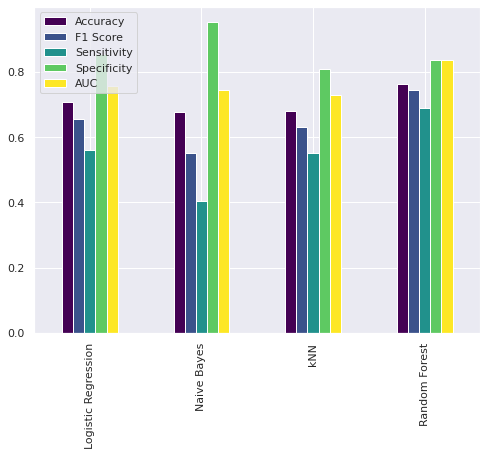

In [25]:
metrics.plot.bar(figsize=(8,6), colormap = 'viridis')
plt.xticks(ticks=[0, 1,2,3], labels=metrics['Classifier'])
plt.show()

## ROC Curves
In order to implement roc curves for kfold cross validation, I used the the code from [ROC Curve with k-Fold](http://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv) notebook.

LogisticRegression(random_state=1)


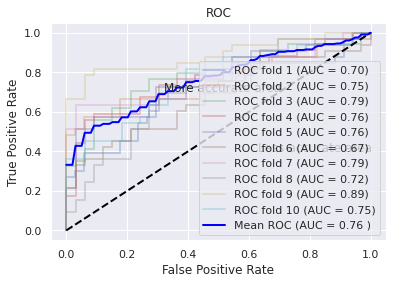

GaussianNB()


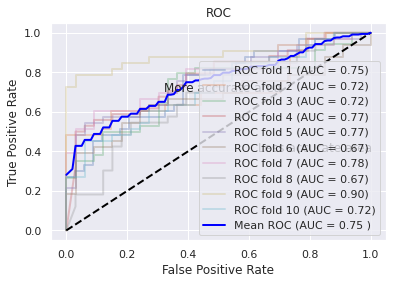

KNeighborsClassifier()


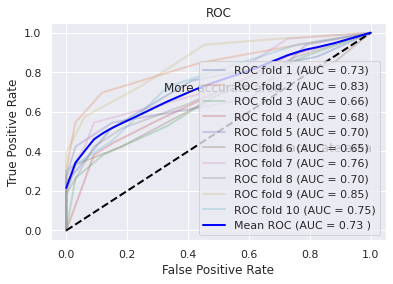

RandomForestClassifier(max_depth=10, min_samples_split=5)


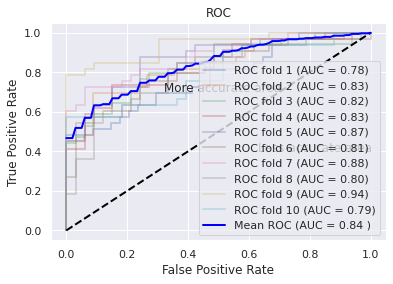

In [26]:
for clf in classifiers:
    print(clf)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    for train_index, test_index in cv.split(X_scaled, y.ravel()):
        prediction = clf.fit(X_scaled[train_index],y.ravel()[train_index]).predict_proba(X_scaled[test_index])
        fpr, tpr, t = roc_curve(y.ravel()[test_index], prediction[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    plt.show()